### Step 0: 把資料下載到本地

In [3]:
import requests
import os

In [4]:
resp = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data")

In [5]:
resp.status_code

200

In [6]:
os.makedirs("data", exist_ok=True)
with open("data/hw1.csv", "w") as f:
    f.write(resp.text)

### Step 1-1: Load the dataset

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv("data/hw1.csv", header=None)

In [9]:
# column names according to http://archive.ics.uci.edu/dataset/19/car+evaluation
#   buying:   vhigh, high, med, low.
#   maint:    vhigh, high, med, low.
#   doors:    2, 3, 4, 5, more.
#   persons:  2, 4, more.
#   lug_boot: small, med, big.
#   safety:   low, med, high.
df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]

In [10]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [12]:
df.nunique() # 相異值的數量

buying      4
maint       4
doors       4
persons     3
lug_boot    3
safety      3
class       4
dtype: int64

In [13]:
df.describe(include='all') # 基本統計資訊

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


In [14]:
for col in df.columns:
    print(df[col].value_counts(), end="\n\n")

buying
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64

maint
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64

doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64

persons
2       576
4       576
more    576
Name: count, dtype: int64

lug_boot
small    576
med      576
big      576
Name: count, dtype: int64

safety
low     576
med     576
high    576
Name: count, dtype: int64

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64



### Step 1-2: Data Cleaning and Transformation
使用 One-Hot Encoding 來處理 Categorical Data  
（可以直接使用 pandas 的 get_dummies）

In [15]:
features = df.columns[:-1]

In [16]:
df_dum = pd.get_dummies(df[features])

In [17]:
df_dum

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,doors_4,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,True,False,True,False
1,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,True
2,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,True,True,False,False
3,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,True,False,False,True,False
4,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,True
1724,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,True,False,False
1725,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,True,False
1726,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,False,True


將 class 分為 good 或 bad

1. unacc: bad
2. acc: bad
3. good: good
4. vgood: good

In [18]:
df_y = df["class"]
df_y.value_counts()

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

In [19]:
df_y = df_y.map({"unacc": 0, "acc": 0, "good": 1, "vgood": 1})

In [20]:
df_y

0       0
1       0
2       0
3       0
4       0
       ..
1723    1
1724    1
1725    0
1726    1
1727    1
Name: class, Length: 1728, dtype: int64

### Step 1-3: Split the data

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_dum, df_y, test_size=0.2, random_state=42)

In [23]:
X_train.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,doors_4,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
107,False,False,False,True,False,False,False,True,False,False,False,True,False,False,True,True,False,False,True,False,False
901,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,True
1709,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,True,False,False,True,False,False
706,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,True
678,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False


In [24]:
y_train.head()

107     0
901     0
1709    0
706     0
678     0
Name: class, dtype: int64

In [25]:
X_test.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,doors_4,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
599,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False
1201,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True
628,True,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True
1498,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True
1263,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False


In [26]:
y_test.head()

599     0
1201    0
628     0
1498    0
1263    0
Name: class, dtype: int64

### Step 2-1: Initialize the  classifier

In [27]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(
    criterion="entropy",
    max_depth = 5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

### Step 2-2: Train the model

In [28]:
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       min_samples_split=10, random_state=42)

### Step 2-3: Make predictions

In [29]:
y_pred = model.predict(X_test)

### Step 3-1: Evaluate performance

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [31]:
accuracy_score(y_test, y_pred)

0.9393063583815029

In [32]:
confusion_matrix(y_test, y_pred)

array([[303,  15],
       [  6,  22]])

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       318
           1       0.59      0.79      0.68        28

    accuracy                           0.94       346
   macro avg       0.79      0.87      0.82       346
weighted avg       0.95      0.94      0.94       346



### Step 3-2: Visualize

In [34]:
from sklearn.tree import plot_tree

[Text(0.7, 0.9166666666666666, 'safety_low <= 0.5\nentropy = 0.39\nsamples = 1382\nvalue = [1276, 106]\nclass = unacc'),
 Text(0.6, 0.75, 'persons_2 <= 0.5\nentropy = 0.518\nsamples = 913\nvalue = [807, 106]\nclass = unacc'),
 Text(0.6499999999999999, 0.8333333333333333, 'True  '),
 Text(0.5, 0.5833333333333334, 'buying_low <= 0.5\nentropy = 0.663\nsamples = 615\nvalue = [509, 106]\nclass = unacc'),
 Text(0.2, 0.4166666666666667, 'buying_med <= 0.5\nentropy = 0.417\nsamples = 463\nvalue = [424, 39]\nclass = unacc'),
 Text(0.1, 0.25, 'entropy = 0.0\nsamples = 313\nvalue = [313, 0]\nclass = unacc'),
 Text(0.3, 0.25, 'maint_low <= 0.5\nentropy = 0.827\nsamples = 150\nvalue = [111, 39]\nclass = unacc'),
 Text(0.2, 0.08333333333333333, 'entropy = 0.396\nsamples = 115\nvalue = [106, 9]\nclass = unacc'),
 Text(0.4, 0.08333333333333333, 'entropy = 0.592\nsamples = 35\nvalue = [5, 30]\nclass = acc'),
 Text(0.8, 0.4166666666666667, 'maint_vhigh <= 0.5\nentropy = 0.99\nsamples = 152\nvalue = [85,

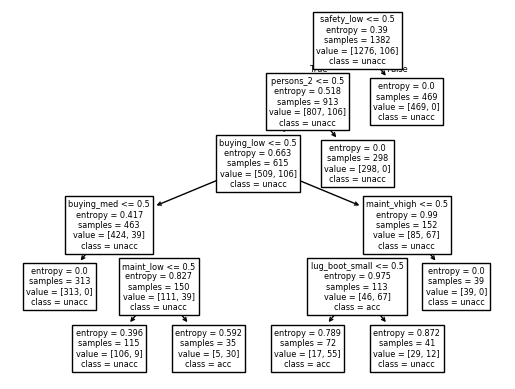

In [35]:
plot_tree(model, feature_names=X_train.columns, class_names=["unacc", "acc", "good", "vgood"])

### Step 4-1: Tune hyperparameters

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "min_samples_split": [5, 10, 15, 20],
    "min_samples_leaf": [2, 4, 6, 8]
}

In [38]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1, # 使用所有 CPU 核心
)

In [39]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                              min_samples_leaf=4,
                                              min_samples_split=10,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [2, 4, 6, 8],
                         'min_samples_split': [5, 10, 15, 20]},
             scoring='accuracy')

### Step 4-2: Evaluate the tuned model

In [40]:
print("最佳參數:", grid_search.best_params_)
print("最佳分數:", grid_search.best_score_)

最佳參數: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}
最佳分數: 0.9891435148851567


In [41]:
# 使用最佳的參數來預測
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       318
           1       0.68      1.00      0.81        28

    accuracy                           0.96       346
   macro avg       0.84      0.98      0.90       346
weighted avg       0.97      0.96      0.97       346



### Bonus: Feature importance analysis

In [45]:
import matplotlib.pyplot as plt

In [46]:
feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_model.feature_importances_
})

In [48]:
# 依照重要性排序
feature_importance = feature_importance.sort_values("importance", ascending=False)
feature_importance

,feature,importance
2,buying_med,0.139768
19,safety_low,0.134896
12,persons_2,0.132005
1,buying_low,0.130192
5,maint_low,0.116962
7,maint_vhigh,0.081585
20,safety_med,0.074764
4,maint_high,0.064304
17,lug_boot_small,0.055506
18,safety_high,0.033311


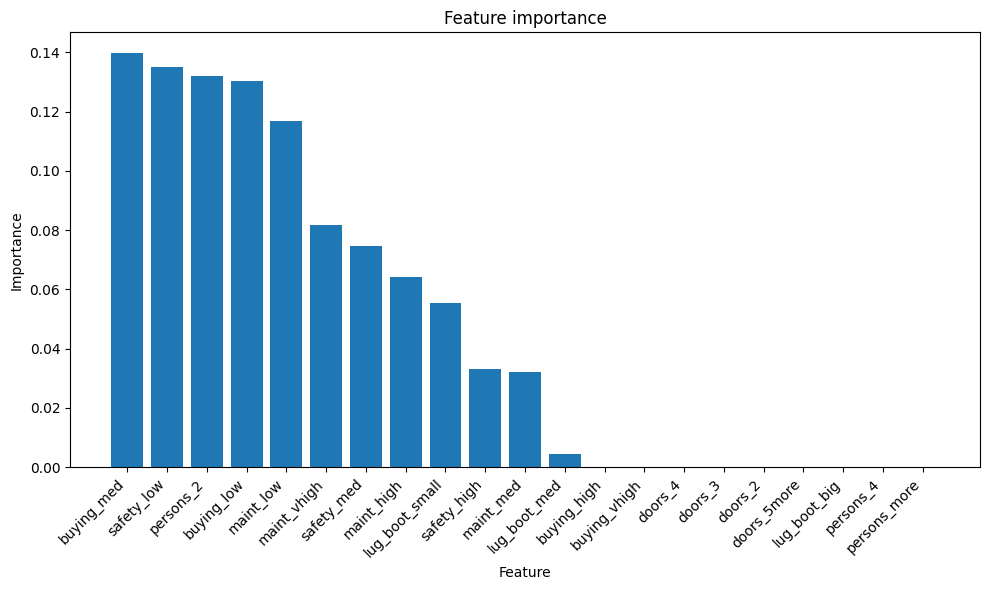

In [49]:
plt.figure(figsize=(10, 6))
plt.bar(feature_importance["feature"], feature_importance["importance"])
plt.xticks(rotation=45, ha="right")
plt.title("Feature importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Step 5: Report Results
詳情請見 `hw1_report.pdf`